In [1]:
import pandas as pd
import numpy as np
import torch
import torchmetrics
import typing
from matplotlib import pyplot as plt
from math import isclose

In [2]:
from utils import get_csv_data


In [3]:
# get data
data = get_csv_data(folder_path="./raw_data")
YEAR = 2021

In [4]:
input_data = data[:-1]
target_data = data[1:]

In [5]:
# flip
features = []
targets = []
for (feature, target) in zip(input_data, target_data): 
    features.append(feature.T)
    targets.append(target.T)

In [6]:
features_np = []
targets_np = []

for (feature, target) in zip(features, targets):
    # feature.drop("Date", axis=0, inplace=True)
    # feature.drop("Time", axis=0, inplace=True)
    # feature.drop("Vol", axis=0, inplace=True)
    # feature.drop("Turn", axis=0, inplace=True)
    feature = feature.loc["C"]
    target = target.loc["C"]

    # feature = (feature - feature.mean())/feature.std()
    # target = (target - target.mean())/target.std()

    features_np.append(feature.to_numpy(dtype=np.float32).reshape(1, len(feature)))
    targets_np.append(target.to_numpy(dtype=np.float32).reshape(1, len(target)))

features_np = np.array(features_np)
targets_np = np.array(targets_np)

In [7]:
targets_np[0].shape

(1, 377)

In [8]:
# dataloader
class StockData(torch.utils.data.Dataset):

    def __init__(self, features, targets):
        self.targets = torch.tensor(targets)  # cast targets to tensor
        self.features = torch.tensor(features)  # calculates total count of unique targets

    def __getitem__(self, index):
        return self.features[index], self.targets[index]

    def __len__(self):
        return len(self.targets)

    def split(self, *split_ratio): 
        '''
        returns torch random split object (this instance) \n
        if numbers > 1 are given: check if sum == len, then pass to torch.utils.data.random_split \n
        if numbers < 1 are given: then the sum must == 1, then compute the length og each portion \n
        '''
        summed = sum(split_ratio)
        if not isclose(summed, 1.0):  # or and abs( 1-sum(split_ratio) ) > 1e-15
            if summed != len(self): # check if the sum == len
                raise ValueError(
                    f"sum of splitted lengths does not match the data length\ninstead of the total of {len(self)} or total ratio of 1, {split_ratio} -> {sum(split_ratio)} were given")  
            self.sizes = split_ratio
        else:  # if sum == 1
            self.sizes = [ int( ratio*len(self) ) for ratio in split_ratio[:-1] ]  # leave one out, the left will be the last term, so that dun need to deal with the rounding problem 
            self.sizes.append(len(self) - sum(self.sizes))  # add the rest instead of the length*ratio, for the last term
        return torch.utils.data.random_split(self, self.sizes)

    def dataloader(self, *args, **kwargs: typing.Any):
        return torch.utils.data.DataLoader(self, *args, **kwargs)

In [130]:
class Encoder(torch.nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super().__init__()

        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2*embedding_dim

        self.rnn = torch.nn.LSTM(
            input_size=self.n_features, 
            hidden_size=self.embedding_dim, 
            batch_first=True, 
            num_layers=1
        )

    def forward(self, x):
        #The input x is fed into the encoder. The code h is then fed into the decoder.
        # x = x.reshape(
        #     (1, self.seq_len, self.n_features)
        # )
        x, (hidden_n, cell_n) = self.rnn(x)
        return hidden_n.reshape((1, self.embedding_dim))


class Decoder(torch.nn.Module):
    def __init__(self, seq_len, input_dim=1, output_dim=377):
        super().__init__()

        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.output_dim = 2*input_dim, output_dim

        self.rnn = torch.nn.LSTM(
            input_size=self.input_dim, 
            hidden_size=self.hidden_dim, 
            batch_first=True, 
            num_layers=1,
            dropout=0
        )

        self.dense_layer = torch.nn.Sequential(
            # torch.nn.Linear(self.hidden_dim, self.hidden_dim),
            # torch.nn.ReLU(), 
            torch.nn.Linear(self.hidden_dim, 1)
        )
        
        torch.nn.Linear(self.hidden_dim, 1)

    def forward(self, x):
        #The input x is fed into the encoder. The code h is then fed into the decoder.

        x = x.repeat(self.seq_len, 1)

        x = x.reshape(
            (1, self.seq_len, self.input_dim)
        )

        x, (hidden_n, cell_n) = self.rnn(x)

        x = x.reshape(
            (self.seq_len, self.hidden_dim)
        )
        x = self.dense_layer(x)
        return x.T

In [131]:
class Autoencoder(torch.nn.Module):
    def __init__(self, seq_len=377, output_size=377, embedding_dim=64):
        super().__init__()
        self.seq_len, self.output_size = seq_len, output_size
        self.enbedding_dim = embedding_dim
        #the encoder should have as input size the size of each data sample and as output size the size of the code.
        #FFN using ReLu as activation function.
        self.encoder = Encoder(self.seq_len, self.output_size, self.enbedding_dim).to(device)
        #the decoder hould have as input size the size of the code and as output size the size of the each data sample.
        #Another FFN using ReLu as activation function. We want separate neural networks for encoder and decoder.
        self.decoder = Decoder(self.seq_len, self.enbedding_dim, self.output_size).to(device)
        
    def forward(self, x):
        #The input x is fed into the encoder. The code h is then fed into the decoder.
        h = self.encoder(x)
        r = self.decoder(h)
        return r

In [132]:
# for .to(device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load data
ready_data = StockData(features_np, targets_np)

# split
split_size = (0.7, 0.25, 0.05)
train_set, test_set, val_set = ready_data.split(*split_size)

In [145]:
gg = Autoencoder(377, 377, 1).to(device)

# parmas for training loop
n_epochs = 10000
params = {
    "batch_size": 1
}

# loss function, optimiser and metrics 
loss_func = torch.nn.MSELoss().to(device)
optimiser = torch.optim.Adam(gg.parameters(), lr=0.01)
metrics = torchmetrics.MeanSquaredError().to(device)

for epoch in range(n_epochs): 
    print(f"epoch {epoch}")
    # training
    for X, y in torch.utils.data.DataLoader(train_set, **params):
        # RNN here
        X, y = X.to(device), y.to(device)
        y = y.squeeze(0)
        outputs = gg(X)
        loss = loss_func(outputs, y)
        loss.backward()
        optimiser.step()
        optimiser.zero_grad()
        metrics(outputs, y)
    met = metrics.compute()
    print(f'train: {met}')

    # test
    for X, y in torch.utils.data.DataLoader(test_set, **params):
        # RNN here
        X, y = X.to(device), y.to(device)
        y = y.squeeze(0)
        outputs = gg(X)
        metrics(outputs, y)
    met = metrics.compute()
    print(f'test: {met}')

epoch 0
train: 628446848.0
test: 632247296.0
epoch 1
train: 630614912.0
test: 632243136.0
epoch 2
train: 631203712.0
test: 632239616.0
epoch 3
train: 631476928.0
test: 632236480.0
epoch 4
train: 631634048.0
test: 632233600.0
epoch 5
train: 631735616.0
test: 632230784.0
epoch 6
train: 631806336.0
test: 632227968.0
epoch 7
train: 631857856.0
test: 632225024.0
epoch 8
train: 631896832.0
test: 632221824.0
epoch 9
train: 631926464.0
test: 632217792.0
epoch 10
train: 631948928.0
test: 632212672.0
epoch 11
train: 631965184.0
test: 632205888.0
epoch 12
train: 631976256.0
test: 632197696.0
epoch 13
train: 631983808.0
test: 632188864.0
epoch 14
train: 631988672.0
test: 632179648.0
epoch 15
train: 631991552.0
test: 632170176.0
epoch 16
train: 631992832.0
test: 632160640.0
epoch 17
train: 631992960.0
test: 632151104.0
epoch 18
train: 631991872.0
test: 632141504.0
epoch 19
train: 631990016.0
test: 632132032.0
epoch 20
train: 631987584.0
test: 632122560.0
epoch 21
train: 631984512.0
test: 632113216.

KeyboardInterrupt: 

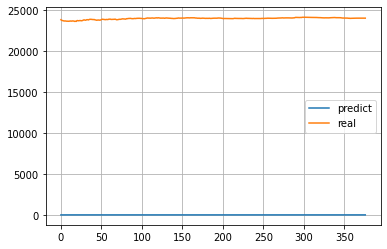

In [146]:
validation = torch.utils.data.DataLoader(val_set, **params)
for i, (X, y) in enumerate(validation): 
    output = gg(X.to(device))
    timesteps = range(torch.flatten(X).shape[0])
    X_pred = torch.flatten(output.cpu().detach())
    y = torch.flatten(y)
    plt.plot(timesteps, X_pred, label="predict")
    plt.plot(timesteps, y, label="real")
    plt.legend()
    plt.grid(True)

In [144]:
X_pred

tensor([5.7281, 7.8880, 8.6725, 8.8649, 8.9098, 8.9209, 8.9239, 8.9248, 8.9251,
        8.9252, 8.9253, 8.9253, 8.9253, 8.9253, 8.9253, 8.9253, 8.9253, 8.9253,
        8.9253, 8.9253, 8.9253, 8.9253, 8.9253, 8.9253, 8.9253, 8.9253, 8.9253,
        8.9253, 8.9253, 8.9253, 8.9253, 8.9253, 8.9253, 8.9253, 8.9253, 8.9253,
        8.9253, 8.9253, 8.9253, 8.9253, 8.9253, 8.9253, 8.9253, 8.9253, 8.9253,
        8.9253, 8.9253, 8.9253, 8.9253, 8.9253, 8.9253, 8.9253, 8.9253, 8.9253,
        8.9253, 8.9253, 8.9253, 8.9253, 8.9253, 8.9253, 8.9253, 8.9253, 8.9253,
        8.9253, 8.9253, 8.9253, 8.9253, 8.9253, 8.9253, 8.9253, 8.9253, 8.9253,
        8.9253, 8.9253, 8.9253, 8.9253, 8.9253, 8.9253, 8.9253, 8.9253, 8.9253,
        8.9253, 8.9253, 8.9253, 8.9253, 8.9253, 8.9253, 8.9253, 8.9253, 8.9253,
        8.9253, 8.9253, 8.9253, 8.9253, 8.9253, 8.9253, 8.9253, 8.9253, 8.9253,
        8.9253, 8.9253, 8.9253, 8.9253, 8.9253, 8.9253, 8.9253, 8.9253, 8.9253,
        8.9253, 8.9253, 8.9253, 8.9253, 